In [1]:
import pandas as pd
from matplotlib import pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
import seaborn as sns
from sklearn.neighbors import KNeighborsClassifier 

In [2]:
data = pd.read_csv("/home/ivana/Desktop/IP-projekat/2023_Data_Mining_Smoking_Dataset/datasets/data1.csv")
data.columns

Index(['Unnamed: 0', 'gender', 'age', 'height(cm)', 'weight(kg)',
       'eyesight(left)', 'hearing(left)', 'hearing(right)', 'relaxation',
       'fasting blood sugar', 'Cholesterol', 'triglyceride', 'HDL',
       'hemoglobin', 'Urine protein', 'serum creatinine', 'AST', 'Gtp',
       'dental caries', 'tartar', 'smoking'],
      dtype='object')

In [3]:
data.drop('Unnamed: 0', axis=1,inplace=True)

In [4]:
data.shape

(55692, 20)

In [5]:
Y = data['smoking']
X = data.drop('smoking', axis=1)
feature_names = X.columns
X.head()

,gender,age,height(cm),weight(kg),eyesight(left),hearing(left),hearing(right),relaxation,fasting blood sugar,Cholesterol,triglyceride,HDL,hemoglobin,Urine protein,serum creatinine,AST,Gtp,dental caries,tartar
0,0,40,155,60,1.2,1.0,1.0,73.0,94.0,215.0,82.0,73.0,12.9,1.0,0.7,18.0,27.0,0,1
1,0,40,160,60,0.8,1.0,1.0,70.0,130.0,192.0,115.0,42.0,12.7,1.0,0.6,22.0,18.0,0,1
2,1,55,170,60,0.8,1.0,1.0,86.0,89.0,242.0,182.0,55.0,15.8,1.0,1.0,21.0,22.0,0,0
3,1,40,165,70,1.5,1.0,1.0,60.0,96.0,322.0,254.0,45.0,14.7,1.0,1.0,19.0,18.0,0,1
4,0,40,155,60,1.0,1.0,1.0,74.0,80.0,184.0,74.0,62.0,12.5,1.0,0.6,16.0,22.0,0,0


Balansiramo klase pre podele na test i trening.

In [6]:
from imblearn.over_sampling import RandomOverSampler

# Balansiranje skupa
ros = RandomOverSampler(random_state=0)
X, Y = ros.fit_resample(X, Y)

In [7]:
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.30, stratify=Y, random_state=12)

Normalizacija

In [8]:
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()
scaler.fit(X_train)
X_train = scaler.transform(X_train)
X_test = scaler.transform(X_test)

In [9]:
from sklearn.decomposition import PCA
pca = PCA(n_components=6)
pca.fit_transform(X_train)


array([[-0.83240927, -0.0109558 ,  0.50706169, -0.11379862,  0.09702704,
         0.08510231],
       [-0.31623547,  0.05175465, -0.40360714,  0.72997825,  0.19052747,
        -0.08718918],
       [ 0.29272672, -0.66203373, -0.05366902, -0.11691028,  0.05647376,
         0.09943285],
       ...,
       [-0.36387354,  0.01008419, -0.40690852,  0.12367163, -0.16036267,
        -0.15369839],
       [ 0.28814166, -0.67121093, -0.05372553, -0.16395985,  0.15829359,
        -0.02361903],
       [-0.41813511, -0.07113772, -0.42441402,  0.16595355, -0.27871096,
         0.20127531]])

In [10]:
pca.components_.shape

(6, 19)

In [11]:
pca_names = [f'Principal_component_{i}' for i in range(pca.n_components_)]

In [12]:
for i, component in enumerate(pca.components_):
    print(f'{pca_names[i]} = ', end='')
    print(' + '.join(f'{coef:.2f}*{feature_name}'
                     for coef, feature_name in zip(component, feature_names)))
    print('-'*80)


Principal_component_0 = -0.49*gender + 0.10*age + -0.14*height(cm) + -0.09*weight(kg) + -0.01*eyesight(left) + 0.02*hearing(left) + 0.01*hearing(right) + -0.02*relaxation + -0.01*fasting blood sugar + 0.00*Cholesterol + -0.05*triglyceride + 0.04*HDL + -0.08*hemoglobin + -0.00*Urine protein + -0.01*serum creatinine + -0.00*AST + -0.02*Gtp + -0.38*dental caries + -0.75*tartar
--------------------------------------------------------------------------------
Principal_component_1 = -0.77*gender + 0.09*age + -0.21*height(cm) + -0.13*weight(kg) + -0.01*eyesight(left) + 0.00*hearing(left) + 0.00*hearing(right) + -0.03*relaxation + -0.01*fasting blood sugar + 0.01*Cholesterol + -0.06*triglyceride + 0.05*HDL + -0.11*hemoglobin + -0.00*Urine protein + -0.02*serum creatinine + -0.00*AST + -0.02*Gtp + 0.09*dental caries + 0.55*tartar
--------------------------------------------------------------------------------
Principal_component_2 = -0.14*gender + -0.02*age + -0.03*height(cm) + -0.02*weight(kg)

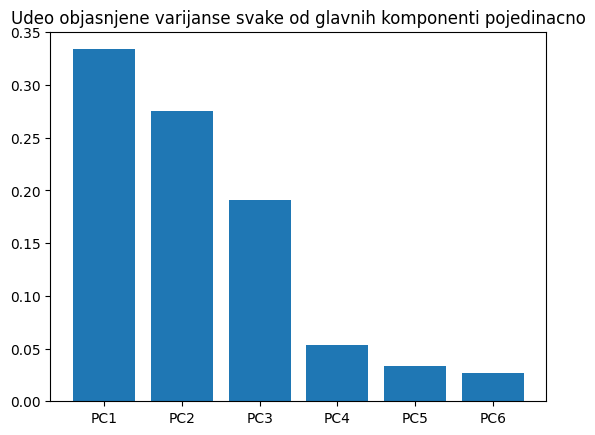

In [13]:
plt.bar(x=['PC1', 'PC2', 'PC3', 'PC4', 'PC5', 'PC6'],
        height=pca.explained_variance_ratio_)
plt.title('Udeo objasnjene varijanse svake od glavnih komponenti pojedinacno')
plt.show()

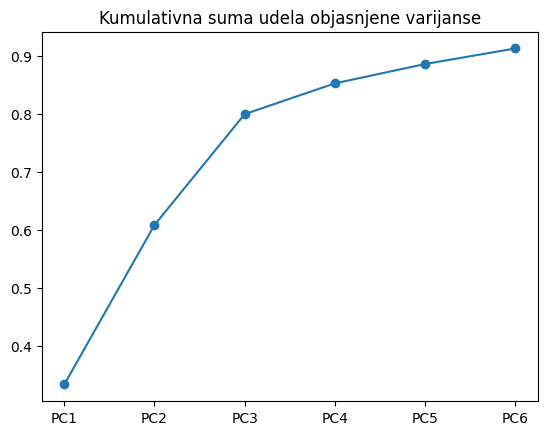

In [14]:
import numpy as np

cumulative_variance_ratio = np.cumsum(pca.explained_variance_ratio_)

plt.plot(['PC1', 'PC2', 'PC3', 'PC4', 'PC5', 'PC6'], cumulative_variance_ratio, marker='o')
plt.title('Kumulativna suma udela objasnjene varijanse')
plt.show()

Mozemo primetiti da prvih sest glavnih komponenti objasnjavaju ukupno vise od 90% ukupne varijanse podataka.

In [15]:
from sklearn.metrics import classification_report
from termcolor import colored

def report(model, x, y, text = "training"):
    y_pred = model.predict(x)
    
    print(colored("Izvestaj o klasifikaciji za model{} nad {} podacima".format(type(model).__name__, text), "green"))
    print("---------------------------------------------------------------------------------")
    print(classification_report(y, y_pred))
    print("---------------------------------------------------------------------------------")
    
    print(colored("Matrica konfuzije za model {} nad {} podacima ".format(type(model).__name__, text), "green"))
    print("---------------------------------------------------------------------------------")
    print(pd.DataFrame(confusion_matrix(y, y_pred), columns=['1', '0'], index=['1', '0']))
    print("---------------------------------------------------------------------------------")
    


treniramo model:

In [16]:
# Kreiranje KNeighborsClassifier modela
knn = KNeighborsClassifier()

# Treniranje modela na balansiranom skupu za treniranje
knn.fit(X_train, Y_train)


KNeighborsClassifier()

In [17]:
report(knn, X_train, Y_train)

Izvestaj o klasifikaciji za modelKNeighborsClassifier nad training podacima
---------------------------------------------------------------------------------
              precision    recall  f1-score   support

           0       0.88      0.79      0.83     24666
           1       0.81      0.89      0.85     24665

    accuracy                           0.84     49331
   macro avg       0.85      0.84      0.84     49331
weighted avg       0.85      0.84      0.84     49331

---------------------------------------------------------------------------------
Matrica konfuzije za model KNeighborsClassifier nad training podacima 
---------------------------------------------------------------------------------
       1      0
1  19462   5204
0   2609  22056
---------------------------------------------------------------------------------


In [18]:
report(knn, X_test, Y_test, "test")

Izvestaj o klasifikaciji za modelKNeighborsClassifier nad test podacima
---------------------------------------------------------------------------------
              precision    recall  f1-score   support

           0       0.79      0.72      0.75     10571
           1       0.74      0.81      0.78     10572

    accuracy                           0.77     21143
   macro avg       0.77      0.77      0.77     21143
weighted avg       0.77      0.77      0.77     21143

---------------------------------------------------------------------------------
Matrica konfuzije za model KNeighborsClassifier nad test podacima 
---------------------------------------------------------------------------------
      1     0
1  7593  2978
0  1969  8603
---------------------------------------------------------------------------------


 F1 score na test skupu je 76.5%. 

# Podesavanje hiper-parametara

In [19]:
from sklearn.model_selection import GridSearchCV
params={
    'n_neighbors':[70,160,180], 
    'weights': ['uniform', 'distance'],
    'p': [1, 2]
}
params1={
    'n_neighbors':[20, 30, 40, 50, 60], 
    'weights': ['uniform', 'distance'],
    'p': [1, 2]
}

In [20]:
knn_cv = GridSearchCV(KNeighborsClassifier(), param_grid=params, cv=5, scoring= 'f1')
knn_cv.fit(X_train, Y_train)

GridSearchCV(cv=5, estimator=KNeighborsClassifier(),
             param_grid={'n_neighbors': [70, 160, 180], 'p': [1, 2],
                         'weights': ['uniform', 'distance']},
             scoring='f1')

In [21]:
knn_cv.best_params_

{'n_neighbors': 70, 'p': 1, 'weights': 'distance'}

In [22]:
knn_cv.best_score_

0.8526637635288867

In [23]:
report(knn_cv.best_estimator_, X_train, Y_train)

Izvestaj o klasifikaciji za modelKNeighborsClassifier nad training podacima
---------------------------------------------------------------------------------
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     24666
           1       1.00      1.00      1.00     24665

    accuracy                           1.00     49331
   macro avg       1.00      1.00      1.00     49331
weighted avg       1.00      1.00      1.00     49331

---------------------------------------------------------------------------------
Matrica konfuzije za model KNeighborsClassifier nad training podacima 
---------------------------------------------------------------------------------
       1      0
1  24666      0
0      0  24665
---------------------------------------------------------------------------------


Iako se cini da dolazi do preprilagođavanja, to nije slucaj. Posto je za najbolji model izabran parametar weight='distance', dakle udaljenost suseda od instance utice na klasifikaciju (sto je sused blizi instanci koju klasifikujemo, njegov "glas" ima vecu tezinu). Kada evaluiramo model nad trening skupom, sve instance za koje trazimo susede, imaju suseda na rastojanju 0 (to su one same) i onda njihova klasa uvek u potpunost odredjuje klasu instance koju klasifikujemo.(Intuitivno, ako je weights='distance' i u skupu za trening postoji identicna instanca onoj koju klasifikujemo, onda ce novoj instanci biti dodeljena ista klasa). A kada pokusamo sa evaluacijom na test skupu, sada instance koje klasifikujemo nemaju susede na razdaljini 0, pa mnogo vise suseda utice na klasifikaciju (pa je i tacnost manja). 

In [24]:
report(knn_cv.best_estimator_, X_test, Y_test, "test")

Izvestaj o klasifikaciji za modelKNeighborsClassifier nad test podacima
---------------------------------------------------------------------------------
              precision    recall  f1-score   support

           0       0.96      0.74      0.83     10571
           1       0.79      0.97      0.87     10572

    accuracy                           0.85     21143
   macro avg       0.87      0.85      0.85     21143
weighted avg       0.87      0.85      0.85     21143

---------------------------------------------------------------------------------
Matrica konfuzije za model KNeighborsClassifier nad test podacima 
---------------------------------------------------------------------------------
      1      0
1  7780   2791
0   340  10232
---------------------------------------------------------------------------------


Vidimo da je f1 score na test skupu 85%, sto znaci da smo podesavanjem parametara uspeli poboljsati model.

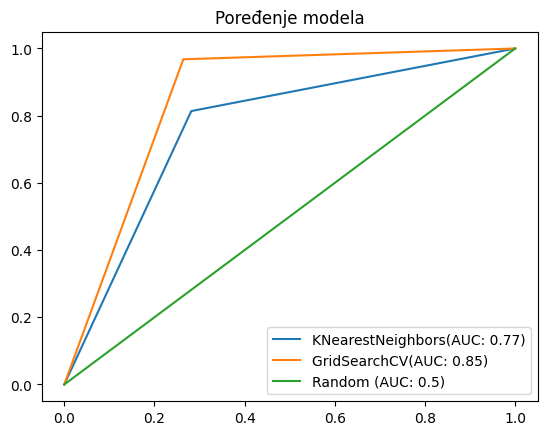

In [25]:
from sklearn.metrics import roc_curve, roc_auc_score
models = [knn, knn_cv.best_estimator_]
model_names = ['KNearestNeighbors', 'GridSearchCV']

for model, model_name in zip(models, model_names):
    y_pred = model.predict(X_test)
    fpr,tpr, _ = roc_curve(Y_test, y_pred)
    auc = roc_auc_score(Y_test, y_pred)
    lab = model_name + "(AUC: " + str(round(auc, 2)) + ")"
    plt.plot(fpr, tpr, label=lab)

plt.plot([0, 1], [0, 1], label='Random (AUC: 0.5)')
plt.title("Poređenje modela")
plt.legend()
plt.show()


Poredjenjem modela zakljucujemo da bolje rezultate daje model sa podesenim parametrima.

In [26]:
from joblib import dump
dump(models, 'knn.joblib')

['knn.joblib']